In [226]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch
from matplotlib.colors import ListedColormap
from itertools import combinations_with_replacement
sns.set_style('white')

project_path = '/stor/work/Lambowitz/cdw2854/bench_marking'
count_table = project_path + '/tRNA_seq/tRNA_counts/count_table.tsv'
frag_cell_table = '/stor/work/Lambowitz/Data/NGS/Matt/results/Counts/tRNA_RAW/MSC1F_S1_R1_001.tRNA'
figure_path = project_path + '/figures'


prep_colors = ['salmon','skyblue','darkviolet']
treatment_colors = ['forestgreen','grey']
def assign_treatment(x,colors=False):
    if 'treated' in x:
        if colors:
            return treatment_colors[1]
        else:
            return 1
    else:
        if colors:
            return treatment_colors[0]
        else:
            return 0

    
def assign_prep(x, colors=False):
    if 'Total' in x:
        if colors:
            return prep_colors[0]
        else:
            return 0
    elif x.startswith('tRNA'):
        if colors:
            return prep_colors[1]
        else:
            return 1
    else:
        if colors:
            return prep_colors[2]
        else:
            return 2
    
amino_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
amino_dict = {k.lower().capitalize():a for k, a in amino_dict.iteritems()}
amino_dict

{'Ala': 'A',
 'Arg': 'R',
 'Asn': 'N',
 'Asp': 'D',
 'Cys': 'C',
 'Gln': 'Q',
 'Glu': 'E',
 'Gly': 'G',
 'His': 'H',
 'Ile': 'I',
 'Leu': 'L',
 'Lys': 'K',
 'Met': 'M',
 'Phe': 'F',
 'Pro': 'P',
 'Ser': 'S',
 'Thr': 'T',
 'Trp': 'W',
 'Tyr': 'Y',
 'Val': 'V'}

In [227]:
cell_frag = pd.read_table(frag_cell_table, names=['tRNA','read_count']) \
    .assign(samplename = 'Fragmented\ntotal cell RNA')
#    .assign(anticodon = lambda d: d.tRNA.str.split('-',expand=True).iloc[:,1]) \
#    .assign(amino = lambda d: d.anticodon.str.slice(0,3).map(amino_dict)) \
#    .assign(anticodon = lambda d: d.anticodon.str.slice(3)) \
#    .assign(tRNA = lambda d: 'TR' + d.amino + '-' + d.anticodon) \
#    .drop(['amino','anticodon'],axis=1) \

cell_frag.head()

,tRNA,read_count,samplename
0,TRT-CGT2-1,46287,Fragmented\ntotal cell RNA
1,TRT-CGT5-1,174,Fragmented\ntotal cell RNA
2,TRK-CTT6-1,3446,Fragmented\ntotal cell RNA
3,TRT-AGT6-1,446,Fragmented\ntotal cell RNA
4,TRQ-CTG9-1,56,Fragmented\ntotal cell RNA


In [228]:
df = pd.concat([cell_frag,pd.read_table(count_table)]) \
    .assign(tRNA = lambda d: d.tRNA.str.replace('[0-9]+-[0-9]+$','')) \
    .assign(tRNA = lambda d: d.tRNA.str.replace('[0-9]+$','')) \
    .assign(tRNA = lambda d: d.tRNA.str.strip('-'))\
    .groupby(['samplename','tRNA'], as_index=False)\
    .sum() \
    .assign(read_count = lambda d: d.read_count.apply(np.log2)) \
    .pipe(pd.pivot_table, index='tRNA', 
          columns = 'samplename',values = 'read_count',fill_value=0)\
    .reset_index()  \
    .pipe(lambda d: d[~d.tRNA.str.contains('MT')]) #\
#    .drop('frag cells',axis=1)

df.head()

samplename,tRNA,Fragmented total cell RNA,Total_RNA_control_1,Total_RNA_control_2,Total_RNA_treated_1,Total_RNA_treated_2,tRNA_control_1,tRNA_control_2,tRNA_treated_1,tRNA_treated_2
20,TRA-AGC,18.022243,15.983973,16.053141,16.897337,16.390555,18.040300,18.362325,18.939614,17.853230
21,TRA-CGC,16.040782,15.527935,15.330917,15.753426,15.292322,15.876085,15.955060,16.804484,16.019830
22,TRA-GGC,3.321928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,TRA-TGC,16.661542,15.945650,16.249984,16.586107,16.177400,15.759212,16.082315,16.959515,16.074999
24,TRC-ACA,2.321928,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000


In [229]:
df.columns = df.columns.str.replace('_',' ')
cor_matrix = df.iloc[:,1:].corr()

In [247]:
def remove_border(ax):
    [ax.spines[direction].set_visible(False) for direction in ['top','bottom','right','left']]
    
def remove_axis(ax):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

def find_linkage(cor_mat, ax):
    d = sch.linkage(cor_mat)
    sch.set_link_color_palette(['k'])
    Z = sch.dendrogram(d, ax = ax,
                       color_threshold=200.0,
                       labels = cor_mat.columns)
    remove_border(ax)
    remove_axis(ax)
    return Z['leaves']

def plot_heatmap(ax, cax, clustered_matrix):
    cmap_name = 'plasma'
    hm = ax.imshow(clustered_matrix,
                cmap=cmap_name,
                aspect='auto',
                vmin = 0.5, vmax=1)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    remove_border(ax)
    ax.xaxis.set_ticks(range(clustered_matrix.shape[1]))
    ax.set_xticklabels(clustered_matrix.columns, rotation=90)
    [xl.set_color(assign_treatment(xl.get_text(),colors=True)) for xl in ax.xaxis.get_ticklabels()]
    
    ax.yaxis.set_ticks(range(clustered_matrix.shape[1]))
    ax.set_yticklabels(clustered_matrix.columns, rotation=0)
    [yl.set_color(assign_treatment(yl.get_text(),colors=True)) for yl in ax.yaxis.get_ticklabels()]
    ax.tick_params(axis='y', which='major', pad=27)
    
    cb = plt.colorbar(hm ,cax = cax)
    cax.text(2.5,0.7,r"Pearson's $\rho$",fontsize=20, 
                rotation=270)
    
def make_image_data(vector):
    return np.array(np.repeat(vector,3)).reshape(len(vector),3)

def plot_color_labeling(ax, mat, cmap, label, add_label = True):
    labeling = ax.imshow(make_image_data(mat),
                        aspect='auto',
                        cmap=cmap)
    remove_axis(ax)
    #remove_border(ax)
    if add_label:
        ax.text(-1.3,8.8,label, rotation=90, fontsize=13)
    return labeling

def plot_color_bar(label_bar, cax, cmap, labels, title):
    cb = plt.colorbar(label_bar, cmap=cmap, cax = cax)
    number_of_labels = len(labels)
    interval = 1.0/number_of_labels
    cax.yaxis.set_ticks(np.arange(0,1,interval) + interval/2)
    cax.set_yticklabels(labels)
    cax.text(0,1.3,title, fontsize=20)

Saved: /stor/work/Lambowitz/cdw2854/bench_marking/figures/tRNA_quant.pdf


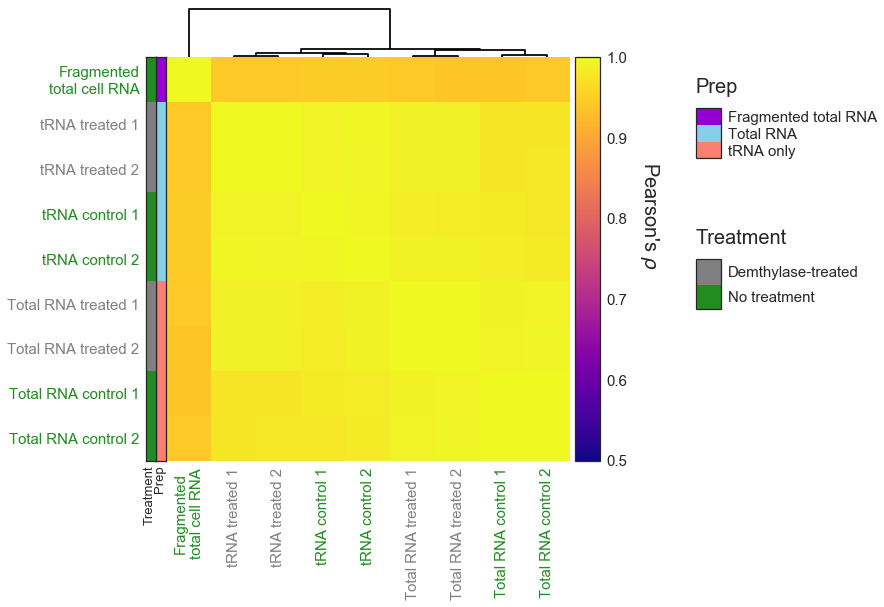

In [248]:
font_args = {'serif':'sans-serif',
            'sans-serif':'Arial'}

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font',**font_args)
fig = plt.figure(figsize=(7,7))
heat_x_start = 0.1
heat_x_width = 0.8
heat_y_start = 0.1
heat_y_height = 0.8
heat_x_end = heat_x_start + heat_x_width
heat_y_end = heat_y_start + heat_y_height

dendro_ax = fig.add_axes([heat_x_start, heat_y_end, heat_x_width, 0.1])
heatmap_ax = fig.add_axes([heat_x_start, heat_y_start, heat_x_width, heat_y_height])
color_ax = fig.add_axes([heat_x_end + 0.01, heat_y_start, 0.05, heat_y_height])
prep_ax = fig.add_axes([heat_x_start - 0.02, heat_y_start, 0.02, heat_y_height ])
prep_color_ax = fig.add_axes([1.15, 0.7,0.05, 0.1])
treatment_ax = fig.add_axes([heat_x_start - 0.04, heat_y_start, 0.02, heat_y_height])
treatment_color_ax = fig.add_axes([1.15, 0.4,0.05, 0.1])

plot_matrix = cor_matrix.reset_index().iloc[:,1:]
leaves = find_linkage(plot_matrix, dendro_ax)
heatmap_matrix = plot_matrix.iloc[leaves,leaves]
plot_heatmap(heatmap_ax, color_ax, heatmap_matrix)


# add prep label colors
prep_cmap = ListedColormap(colors=prep_colors)
prep_labels = heatmap_matrix.columns.map(assign_prep)
cbar = plot_color_labeling(prep_ax, prep_labels, prep_cmap,'Prep')
plot_color_bar(cbar, prep_color_ax, prep_cmap, ['tRNA only','Total RNA','Fragmented total RNA'], 'Prep')

# add treatment label colors
treatment_cmap = ListedColormap(colors=treatment_colors)
treatment_labels = heatmap_matrix.columns.map(assign_treatment)
cbar = plot_color_labeling(treatment_ax, treatment_labels, treatment_cmap,'Treatment')
plot_color_bar(cbar, treatment_color_ax, treatment_cmap, 
               ['No treatment','Demthylase-treated'], 'Treatment')
figurename = figure_path + '/tRNA_quant.pdf'
fig.savefig(figurename, bbox_inches='tight')
print 'Saved: %s' %figurename

Saved: /stor/work/Lambowitz/cdw2854/bench_marking/figures/tRNA_scatter.pdf


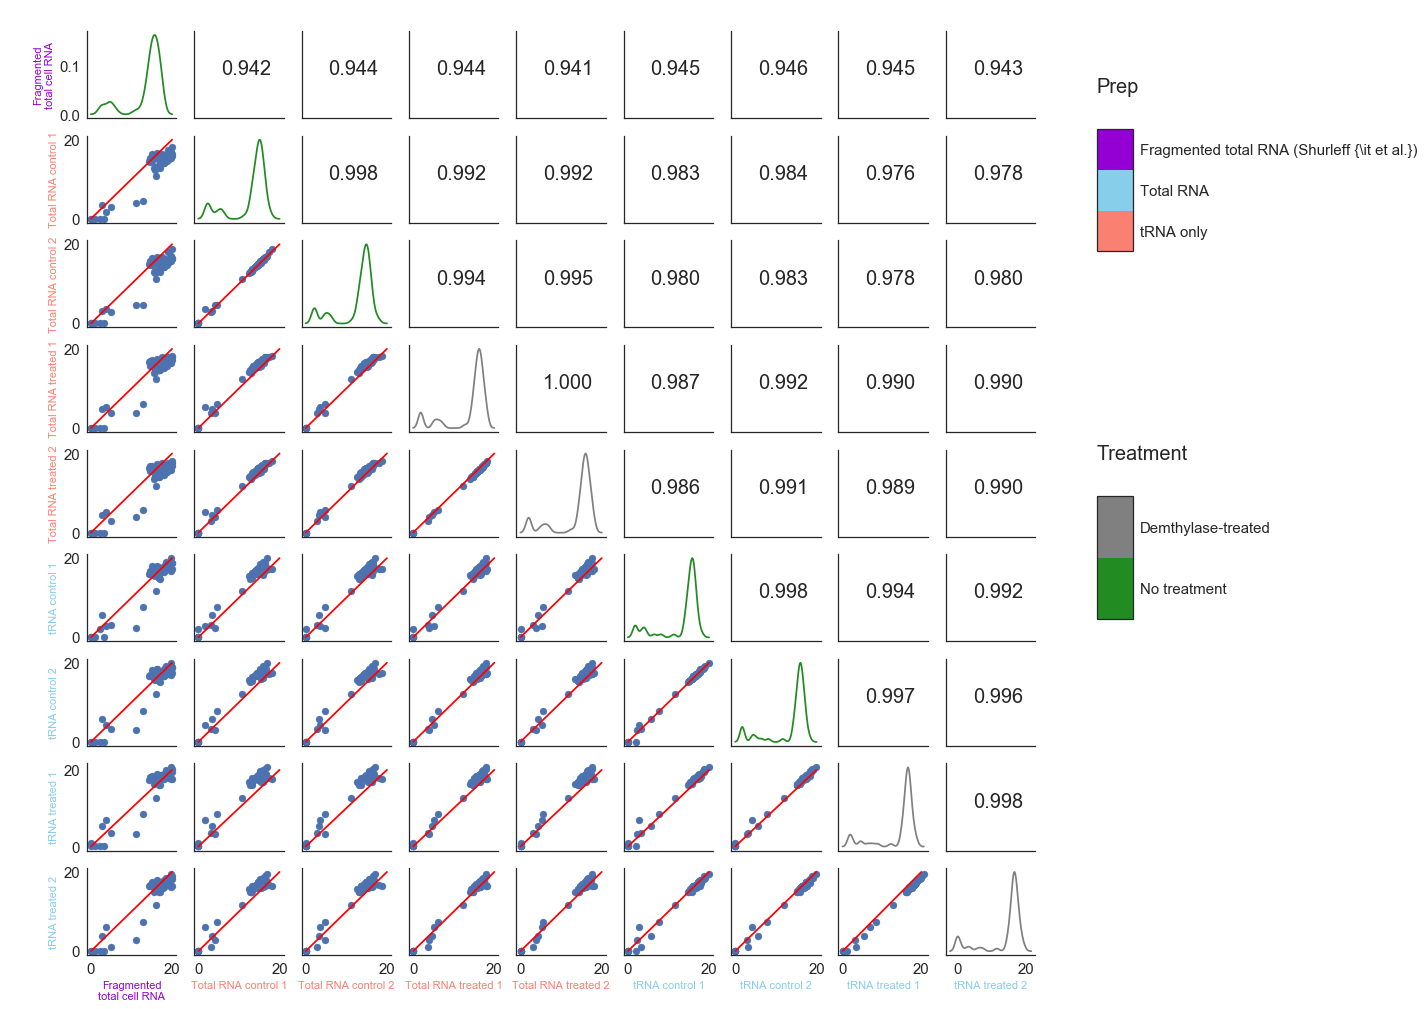

In [252]:
plot_df = df.iloc[:,1:]
fig = plt.figure(figsize=(17,17))
box_size = len(plot_df.columns) 
for row in range(box_size):
    for col in range(box_size):
        ax = fig.add_subplot(box_size, box_size, row * box_size + col + 1)
        if col < row:
            ax.scatter(plot_df.iloc[:,col], plot_df.iloc[:,row])
            ax.plot([0,20],[0,20], color='red')
        elif col == row:
            sns.distplot(plot_df.iloc[:,row], 
                     ax = ax, color = assign_treatment(plot_df.columns[row], colors=True),
                    hist=False)
        else:
            correlation = plot_df.iloc[:,[col,row]].corr().reset_index().iloc[1,1]
            ax.text(0.3, 0.5, '%.3f' %correlation, fontsize=20)
            [ax.spines[way].set_visible(False)  for way in ['bottom','left']]
        sns.despine()
        
        if col != 0:
            ax.yaxis.set_visible(False)
        else:
            label = plot_df.columns[row]
            ax.set_ylabel(label, color = assign_prep(label, colors=True))
            
        if row != box_size -1:
            ax.xaxis.set_visible(False)
        else:
            label = plot_df.columns[col]
            ax.set_xlabel(label, color = assign_prep(label, colors=True))        
            
prep_ax = fig.add_axes([heat_x_start - 0.02, heat_y_start, 0.02, heat_y_height ])
prep_color_ax = fig.add_axes([0.95, 0.7, 0.03, 0.1])
treatment_ax = fig.add_axes([heat_x_start - 0.04, heat_y_start, 0.02, heat_y_height])
treatment_color_ax = fig.add_axes([0.95, 0.4,0.03, 0.1])
# add prep label colors
prep_cmap = ListedColormap(colors=prep_colors)
prep_labels = heatmap_matrix.columns.map(assign_prep)
cbar = plot_color_labeling(prep_ax, prep_labels, prep_cmap,'Prep', add_label=False)
plot_color_bar(cbar, prep_color_ax, prep_cmap, ['tRNA only','Total RNA','Fragmented total RNA (Shurleff {\it et al.})'], 'Prep')
cbar.set_visible(False)
prep_ax.set_axis_off()
# add treatment label colors
treatment_cmap = ListedColormap(colors=treatment_colors)
treatment_labels = heatmap_matrix.columns.map(assign_treatment)
cbar = plot_color_labeling(treatment_ax, treatment_labels, treatment_cmap,'Treatment', add_label=False)
plot_color_bar(cbar, treatment_color_ax, treatment_cmap, 
               ['No treatment','Demthylase-treated'], 'Treatment')
treatment_ax.set_axis_off()
cbar.set_visible(False)


figurename = figure_path + '/tRNA_scatter.pdf'
fig.savefig(figurename, bbox_inches='tight')
print 'Saved: %s' %figurename